# ITU 5G Energy Consumption Challenge - GitData

<font color="red">Please make a copy of this Jupyter Notebook to your own Google Drive or local machine before changing anything.</font>

This Jupyter Notebook will also be updated regularly on GitHub: https://github.com/GitData-GA/itu5g/tree/main/code/ITU_5G_Energy_Consumption_Challenge.ipynb

In [1]:
# Import all libraries here
import random
random.seed(88)
import pandas as pd
import numpy as np
np.random.seed(88)
import tensorflow as tf
tf.random.set_seed(88)
from tensorflow import keras
keras.utils.set_random_seed(88)
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import pyplot as plt

In [2]:
# Output format
# Description: The file contains days, hours, and base stations for which we
# need energy consumption estimation and will be used for scoring predictions.
power_pred = pd.read_csv('https://data.gd.edu.kg/bwz7t527/power_consumption_prediction.csv')
# Dataset 1
# Description: Energy consumption data (ECdata.csv): include hour-level energy
# consumption specifications (e.g., total energy consumption of the base stations).
ECdata = pd.read_csv('https://data.gd.edu.kg/bwz7t527/ECdata.csv')
# Dataset 2
# Description: Cell-level data (CLdata.csv): include hour-level counters,
# including service compliance counters (e.g., load) and energy-saving methods
# counters (e.g., duration of energy saving mode activation).
CLdata = pd.read_csv('https://data.gd.edu.kg/bwz7t527/CLdata.csv')
# Dataset 3
# Description: Base Station basic information (BSinfo.csv): include
# configuration parameters and hardware attributes
BSinfo = pd.read_csv('https://data.gd.edu.kg/bwz7t527/BSinfo.csv')

In [3]:
data = ECdata.merge(CLdata, on=["Time", "BS"], how="inner")
data = data.merge(BSinfo, on="BS", how="inner")
data = data.sort_values(by='Time', ascending=True)
# Convert date strings to datetime objects
data['Time'] = pd.to_datetime(data['Time'])

# Sort the dataset by date
data.sort_values(by='Time', inplace=True)

# Split Year, Month, Day, and Hour
data['Year'] = data['Time'].dt.year
data['Month'] = data['Time'].dt.month
data['Day'] = data['Time'].dt.day
data['Hour'] = data['Time'].dt.hour

# Extract target variable 'Energy'
y = data['Energy']

# Drop unnecessary columns (e.g., 'Time', 'Energy')
data.drop(columns=['Time', 'Energy'], inplace=True)

# One-hot encode categorical features
categorical_cols = ['BS', 'CellName_x', 'CellName_y', 'RUType', 'Mode', ]
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Standardize numerical features
scaler = StandardScaler()
data_encoded[data_encoded.columns] = scaler.fit_transform(data_encoded[data_encoded.columns])

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(data_encoded, y, test_size=0.2, shuffle=False)

# Convert data to numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
# Time series transformation
X_train_ts = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_ts = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [4]:
# LSTM Model - Time series
lstm_model = keras.Sequential([
    layers.LSTM(units=128, recurrent_dropout=0.123),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=1, activation='linear')
])

# Compile the model
lstm_model.compile(optimizer='Adam', loss='mean_absolute_percentage_error',
                   metrics=['mean_absolute_percentage_error'])

# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = lstm_model.fit(X_train_ts, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks = [callback])

# Fit model on validation set and get error
y_pred = lstm_model.predict(X_test_ts)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE on test set: {100 * mape:.5f}')

lstm_model.summary()

Epoch 1/50
2514/2514 [==============================] - 41s 14ms/step - loss: 26.4283 - mean_absolute_percentage_error: 26.4283 - val_loss: 8.6521 - val_mean_absolute_percentage_error: 8.6521
Epoch 2/50
2514/2514 [==============================] - 33s 13ms/step - loss: 14.1894 - mean_absolute_percentage_error: 14.1894 - val_loss: 7.7923 - val_mean_absolute_percentage_error: 7.7923
Epoch 3/50
2514/2514 [==============================] - 34s 13ms/step - loss: 12.5912 - mean_absolute_percentage_error: 12.5912 - val_loss: 7.8194 - val_mean_absolute_percentage_error: 7.8194
Epoch 4/50
2514/2514 [==============================] - 33s 13ms/step - loss: 11.6850 - mean_absolute_percentage_error: 11.6850 - val_loss: 7.0728 - val_mean_absolute_percentage_error: 7.0728
Epoch 5/50
2514/2514 [==============================] - 34s 14ms/step - loss: 10.7836 - mean_absolute_percentage_error: 10.7836 - val_loss: 6.4319 - val_mean_absolute_percentage_error: 6.4319
Epoch 6/50
2514/2514 [==================

Text(0.5, 1.0, 'Validation Loss vs. Epoch')

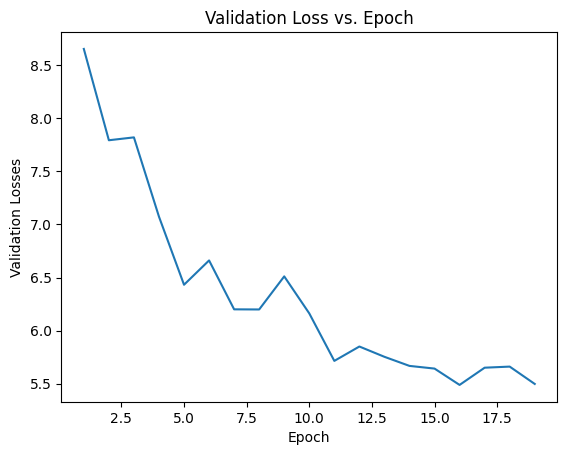

In [5]:
val_loss = history.history["val_loss"]
plt.plot(np.arange(1,len(val_loss)+1), val_loss, label='val loss')
plt.xlabel("Epoch")
plt.ylabel("Validation Losses")
plt.title("Validation Loss vs. Epoch")

In [12]:
# GRU Model - Time series
gru_model = keras.Sequential([
    layers.GRU(units=128, recurrent_dropout=0.123),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=1, activation='linear')
])

# Compile the model
gru_model.compile(optimizer='Adam', loss='mean_absolute_percentage_error',
                   metrics=['mean_absolute_percentage_error'])

# Train the model
history = gru_model.fit(X_train_ts, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks = [callback])

# Fit model on validation set and get error
y_pred = gru_model.predict(X_test_ts)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE on test set: {100 * mape:.5f}')

gru_model.summary()

Epoch 1/50
2514/2514 [==============================] - 38s 13ms/step - loss: 24.9200 - mean_absolute_percentage_error: 24.9200 - val_loss: 9.2638 - val_mean_absolute_percentage_error: 9.2638
Epoch 2/50
2514/2514 [==============================] - 32s 13ms/step - loss: 14.5608 - mean_absolute_percentage_error: 14.5608 - val_loss: 8.3311 - val_mean_absolute_percentage_error: 8.3311
Epoch 3/50
2514/2514 [==============================] - 33s 13ms/step - loss: 12.7461 - mean_absolute_percentage_error: 12.7461 - val_loss: 7.6389 - val_mean_absolute_percentage_error: 7.6389
Epoch 4/50
2514/2514 [==============================] - 31s 13ms/step - loss: 11.5980 - mean_absolute_percentage_error: 11.5980 - val_loss: 6.9905 - val_mean_absolute_percentage_error: 6.9905
Epoch 5/50
2514/2514 [==============================] - 32s 13ms/step - loss: 10.7082 - mean_absolute_percentage_error: 10.7082 - val_loss: 6.4596 - val_mean_absolute_percentage_error: 6.4596
Epoch 6/50
2514/2514 [==================

Text(0.5, 1.0, 'Validation Loss vs. Epoch')

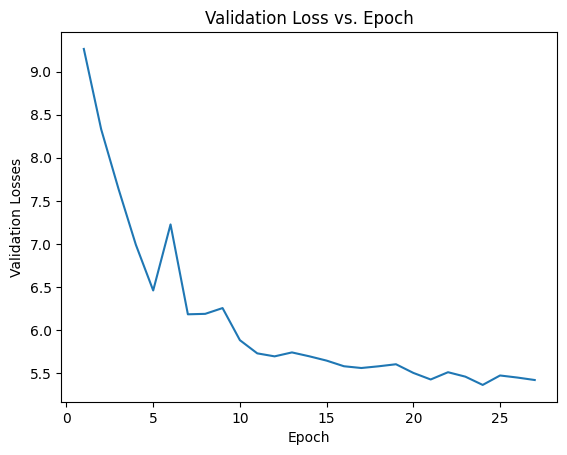

In [13]:
val_loss = history.history["val_loss"]
plt.plot(np.arange(1,len(val_loss)+1), val_loss, label='val loss')
plt.xlabel("Epoch")
plt.ylabel("Validation Losses")
plt.title("Validation Loss vs. Epoch")

In [8]:
# RNN Model - Time series
rnn_model = keras.Sequential([
    layers.SimpleRNN(units=128, recurrent_dropout=0.123),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=1, activation='linear')
])

# Compile the model
rnn_model.compile(optimizer='Adam', loss='mean_absolute_percentage_error',
                   metrics=['mean_absolute_percentage_error'])

# Train the model
history = rnn_model.fit(X_train_ts, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks = [callback])

# Fit model on validation set and get error
y_pred = rnn_model.predict(X_test_ts)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE on test set: {100 * mape:.5f}')

rnn_model.summary()

Epoch 1/50
2514/2514 [==============================] - 27s 9ms/step - loss: 26.1728 - mean_absolute_percentage_error: 26.1728 - val_loss: 8.7326 - val_mean_absolute_percentage_error: 8.7326
Epoch 2/50
2514/2514 [==============================] - 22s 9ms/step - loss: 14.0250 - mean_absolute_percentage_error: 14.0250 - val_loss: 7.3382 - val_mean_absolute_percentage_error: 7.3382
Epoch 3/50
2514/2514 [==============================] - 22s 9ms/step - loss: 12.6229 - mean_absolute_percentage_error: 12.6229 - val_loss: 7.4174 - val_mean_absolute_percentage_error: 7.4174
Epoch 4/50
2514/2514 [==============================] - 22s 9ms/step - loss: 11.8311 - mean_absolute_percentage_error: 11.8311 - val_loss: 6.9832 - val_mean_absolute_percentage_error: 6.9832
Epoch 5/50
2514/2514 [==============================] - 22s 9ms/step - loss: 11.0574 - mean_absolute_percentage_error: 11.0574 - val_loss: 6.7415 - val_mean_absolute_percentage_error: 6.7415
Epoch 6/50
2514/2514 [=======================

Text(0.5, 1.0, 'Validation Loss vs. Epoch')

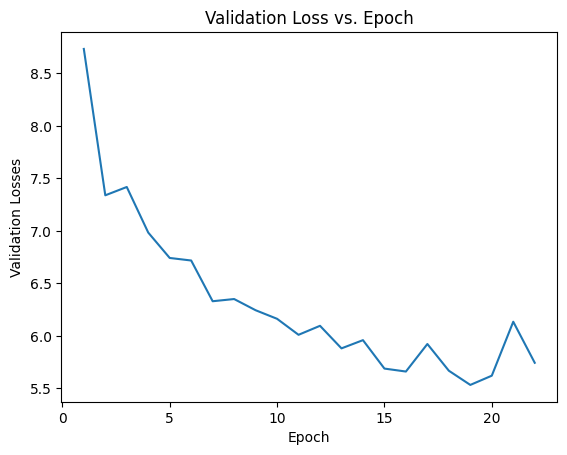

In [9]:
val_loss = history.history["val_loss"]
plt.plot(np.arange(1,len(val_loss)+1), val_loss, label='val loss')
plt.xlabel("Epoch")
plt.ylabel("Validation Losses")
plt.title("Validation Loss vs. Epoch")

In [10]:
# Regression Model - Regression
model = keras.Sequential([
    layers.Dense(units=128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(units=16, activation='relu'),
    layers.Dense(units=1, activation='linear')
])

# Compile the model
model.compile(optimizer='Adam', loss='mean_absolute_percentage_error',
                   metrics=['mean_absolute_percentage_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks = [callback])

# Fit model on validation set and get error
y_pred = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE on test set: {100 * mape:.5f}')

model.summary()

Epoch 1/50
2514/2514 [==============================] - 21s 7ms/step - loss: 26.6042 - mean_absolute_percentage_error: 26.6042 - val_loss: 8.6052 - val_mean_absolute_percentage_error: 8.6052
Epoch 2/50
2514/2514 [==============================] - 17s 7ms/step - loss: 14.3402 - mean_absolute_percentage_error: 14.3402 - val_loss: 7.6284 - val_mean_absolute_percentage_error: 7.6284
Epoch 3/50
2514/2514 [==============================] - 19s 7ms/step - loss: 12.8613 - mean_absolute_percentage_error: 12.8613 - val_loss: 7.4605 - val_mean_absolute_percentage_error: 7.4605
Epoch 4/50
2514/2514 [==============================] - 17s 7ms/step - loss: 11.9331 - mean_absolute_percentage_error: 11.9331 - val_loss: 6.9052 - val_mean_absolute_percentage_error: 6.9052
Epoch 5/50
2514/2514 [==============================] - 17s 7ms/step - loss: 11.1978 - mean_absolute_percentage_error: 11.1978 - val_loss: 6.8977 - val_mean_absolute_percentage_error: 6.8977
Epoch 6/50
2514/2514 [=======================

Text(0.5, 1.0, 'Validation Loss vs. Epoch')

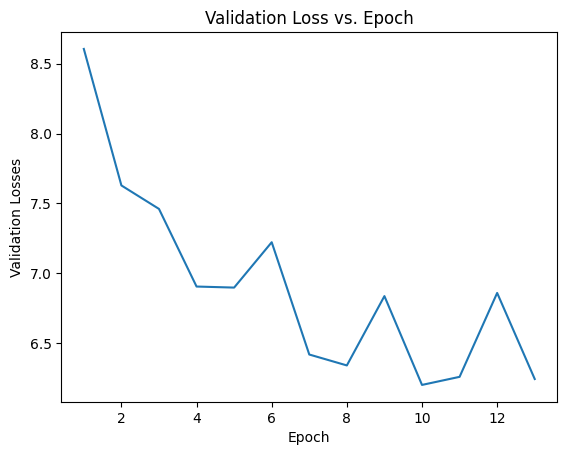

In [11]:
val_loss = history.history["val_loss"]
plt.plot(np.arange(1,len(val_loss)+1), val_loss, label='val loss')
plt.xlabel("Epoch")
plt.ylabel("Validation Losses")
plt.title("Validation Loss vs. Epoch")